# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [42]:
import pandas as pd
import time
import datetime
import os
import numpy as np
import re

from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from catboost import CatBoostClassifier

from pymystem3 import Mystem
from nltk.corpus import stopwords

pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('seaborn-deep')
STATE = 12345

In [2]:
# напишем функцию для поиска файла на локальном диске: 
def find(name, path):
    '''
    Function to find the data file stored locally.
    Takes name of the file and root directory.
    Scanes the local directory tree for the first orrurance of the file.
    '''
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

In [3]:
# найдем файл на диске или онлайн: 

online_path = 'datasets'
offline_path = '/home/'
file = 'toxic_comments.csv'


try:
    df = pd.read_csv(f'/{online_path}/{file}')
except FileNotFoundError:
    df = pd.read_csv(find(file, offline_path))
    print(f"Файл {file} найден на локальном диске.")
else:
    print(f"Файл {file} открыт в режиме online.")

Файл toxic_comments.csv найден на локальном диске.


### Развёрнутая сводка по датафрейму

In [4]:
start = "\033[1m"
end = "\033[0;0m"
print(
    f"Внешний вид первых пяти строк датафрейма {start}{str(file).split('.')[0].upper()}{end}:"
)
display(df.head())
print()
print(f"Размер датафрейма {start}{str(file).split('.')[0].upper()}{end}: \
        \nколичество строк - {df.shape[0]}, \nколичество столбцов - {df.shape[1]}."
      )
print()
print(
    f"Развернутая сводка датафрейма {start}{str(file).split('.')[0].upper()}{end} \nпо наименованию столбцов, типу данных, ненулевых значениях и объему памяти:"
)
print()
df.info(show_counts=True, memory_usage='deep')
print()
print(
    f"Пропуски в столбцах датафрейма {start}{str(file).split('.')[0].upper()}{end}:"
)
display(df.isna().sum())
print()
print(
    f"Уникальные значения столбца toxic датафрейма {start}{str(file).split('.')[0].upper()}{end}:"
)
df.toxic.value_counts()


Внешний вид первых пяти строк датафрейма TOXIC_COMMENTS:


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0



Размер датафрейма TOXIC_COMMENTS:         
количество строк - 159571, 
количество столбцов - 2.

Развернутая сводка датафрейма TOXIC_COMMENTS 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 80.1 MB

Пропуски в столбцах датафрейма TOXIC_COMMENTS:


text     0
toxic    0
dtype: int64


Уникальные значения столбца toxic датафрейма TOXIC_COMMENTS:


0    143346
1     16225
Name: toxic, dtype: int64

### _Промежуточные выводы_

После загрузки датафрейм не содержит пропусков. Необходимо будет проверить пропуски в столбце __*text*__ после лемматизации и стемминга. 
<br>Количество нетоксичных комментариев превышает количество токсичных в 8.8 раз, т.е потребуется нормализация данных на этапе разделения данных и обучения моделей. 

### Стемминг и очистка текста от символов 

In [5]:
%%time

m = Mystem()

def lemmatize_text(text):
    text = text.lower()
    lemm_text = "".join(m.lemmatize(text))
    cleared_text = re.sub(r"[^a-zA-Z]", ' ', lemm_text) 
    return " ".join(cleared_text.split())

df['lemm_text'] = df['text'].apply(lemmatize_text)

df = df.drop(['text'], axis=1)

CPU times: user 52.3 s, sys: 6.66 s, total: 59 s
Wall time: 2min 9s


In [6]:
df.head()

,toxic,lemm_text
0,0,explanation why the edits made under my userna...
1,0,d aww he matches this background colour i m se...
2,0,hey man i m really not trying to edit war it s...
3,0,more i can t make any real suggestions on impr...
4,0,you sir are my hero any chance you remember wh...


### Разделение данных 

In [7]:
target = df['toxic']
features = df.drop(['toxic'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.25,
    random_state=STATE)

In [8]:
stop_words = set(stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stop_words)

In [9]:
features_train = count_tf_idf.fit_transform(
    features_train['lemm_text'].values)

features_test = count_tf_idf.transform(
    features_test['lemm_text'].values)

In [10]:
print(f'Размеры обучающей выборки: {features_train.shape}')
print(f'Размеры тестовой выборки: {features_test.shape}')

Размеры обучающей выборки: (119678, 144264)
Размеры тестовой выборки: (39893, 144264)


### Проверка f1 на Логистической регрессии

In [11]:
%%time

model = LogisticRegression(solver='liblinear')
f1_train_lr = cross_val_score(model,
                           features_train,
                           target_train,
                           cv=10,
                           scoring='f1').mean()
print(f'F1 на кроссвалидации модели {model}', round(f1_train_lr, 3))

F1 на кроссвалидации модели LogisticRegression(solver='liblinear') 0.712
CPU times: user 47.6 s, sys: 1.54 s, total: 49.2 s
Wall time: 12.4 s


### _Промежуточные выводы_

Дисбаланс классов дает достаточно низкое значение f1 на обучающей выборке. Необходимо провести классы к сбалансированному состоянию.  

### Балансирование классов на Логистической регрессии

In [12]:
%%time
# проверим встроенную опцию class_weight:

model = LogisticRegression(class_weight='balanced', solver='liblinear')
f1_train_lr_balanced = cross_val_score(model,
                                       features_train,
                                       target_train,
                                       cv=10,
                                       scoring='f1').mean()
print(
    f'F1 на кроссвалидации модели \n{model} \nсо сбалансированными классами\n',
    round(f1_train_lr_balanced, 3))

F1 на кроссвалидации модели 
LogisticRegression(class_weight='balanced', solver='liblinear') 
со сбалансированными классами
 0.753
CPU times: user 1min 5s, sys: 2.44 s, total: 1min 7s
Wall time: 17 s


In [13]:
%%time
class_ratio = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]
classes = {0: 1, 1: class_ratio}
model = LogisticRegression(class_weight=classes, solver='liblinear')
f1_train_lr_balanced_dict = cross_val_score(model,
                                            features_train,
                                            target_train,
                                            cv=10,
                                            scoring='f1').mean()
print(
    f'F1 на кроссвалидации модели \n{model} \nсо сбалансированными классами\n',
    round(f1_train_lr_balanced_dict, 3))

F1 на кроссвалидации модели 
LogisticRegression(class_weight={0: 1, 1: 8.834884437596301},
                   solver='liblinear') 
со сбалансированными классами
 0.76
CPU times: user 1min 15s, sys: 2.88 s, total: 1min 18s
Wall time: 19.7 s


Использование словаря классов повышает значение f1. Построим ROC-AUC кривую для сравнения результатов до и после балансирования.

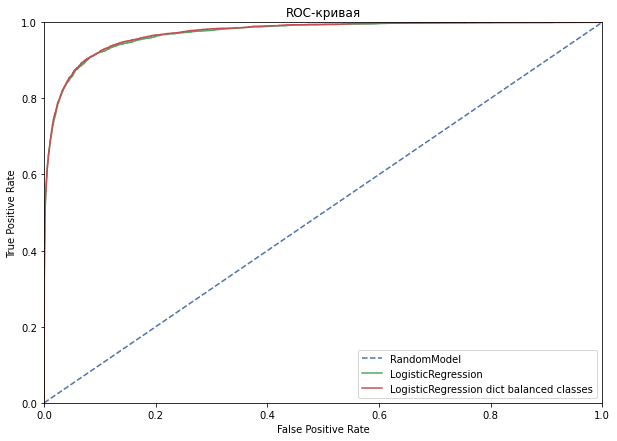

In [14]:
plt.figure(figsize=[10,7])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = LogisticRegression(solver='liblinear')
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
test_f1 = f1_score(target_test, model.predict(features_test))
plt.plot(fpr, tpr, label='LogisticRegression')

model = LogisticRegression(class_weight=classes, solver='liblinear')
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc_balanced = roc_auc_score(target_test, probabilities_one_test)
test_f1_balanced = f1_score(target_test, model.predict(features_test))
plt.plot(fpr, tpr, label='LogisticRegression dict balanced classes')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right')

plt.title("ROC-кривая");

### Вывод

Данные очищены и подготовлены для обучения моделей. Балансирование классов с использованием словаря дает несколько более высокий результат на Логистической регресси. 

## Обучение

### LogisticRegression

In [15]:
# напишем функцию для моделей LogisticRegression и DecisionTreeClassifier:
def model_train(model, model_selector, param_grid, features_train,
                features_test):
    start = time.time()
    grid = model_selector(model,
                          param_grid,
                          cv=10,
                          scoring='f1',
                          n_jobs=-1)

    grid.fit(
        features_train,
        target_train,
    )

    end = time.time()
    train_time = datetime.timedelta(seconds=(end - start))
    best_model = grid.best_estimator_
    print('Наилучшие параметры модели на обучающей выборке:')
    print()
    print(best_model)
    print(grid.best_params_)

    means = grid.cv_results_['mean_test_score']

    print(f'Наилучшее значение f1 модели {best_model}: {round(max(means), 3)}\
    \nВремя обучения: {train_time}')
    print()
    print(
        '********************************************************************************'
    )
    print()

    start = time.time()
    prediction = grid.predict(features_test)
    end = time.time()
    execution_time = datetime.timedelta(seconds=(end - start))

    print(
        f'Среднее значение f1 для модели {model} на тестовой выборке: {round(f1_score(target_test, prediction), 3)}\
    \nВремя предсказания: {execution_time}')
    model_dict = {
        'Model': model,
        'Train time': train_time.total_seconds(),
        'Predict time': execution_time.total_seconds(),
        'Train f1': round(max(means), 3),
        'Test f1': round(f1_score(target_test, prediction), 3),
    }
    return model_dict

In [16]:
param_grid = [{
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'C': [0.1, 1, 10],
    'class_weight': [classes], 
    'random_state': [STATE]
}]

In [17]:
lr_results = model_train(model=LogisticRegression(),
                       model_selector=GridSearchCV,
                       param_grid=param_grid,
                       features_train=features_train,
                       features_test=features_test)
lr_results

Наилучшие параметры модели на обучающей выборке:

LogisticRegression(C=10, class_weight={0: 1, 1: 8.834884437596301},
                   random_state=12345, solver='liblinear')
{'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'random_state': 12345, 'solver': 'liblinear'}
Наилучшее значение f1 модели LogisticRegression(C=10, class_weight={0: 1, 1: 8.834884437596301},
                   random_state=12345, solver='liblinear'): 0.767    
Время обучения: 0:02:24.047249

********************************************************************************

Среднее значение f1 для модели LogisticRegression() на тестовой выборке: 0.768    
Время предсказания: 0:00:00.004374


{'Model': LogisticRegression(),
 'Train time': 144.047249,
 'Predict time': 0.004374,
 'Train f1': 0.767,
 'Test f1': 0.768}

### DecisionTreeClassifier

In [18]:
depth = [x for x in range(785, 787)]
param_grid = [{
    'criterion': ['entropy'],
    'max_depth': depth,
    'class_weight': [classes], 
    'random_state': [STATE],
}]

In [19]:
dt_results = model_train(model=DecisionTreeClassifier(),
                       model_selector=GridSearchCV,
                       param_grid=param_grid,
                       features_train=features_train,
                       features_test=features_test)
dt_results

Наилучшие параметры модели на обучающей выборке:

DecisionTreeClassifier(class_weight={0: 1, 1: 8.834884437596301},
                       criterion='entropy', max_depth=785, random_state=12345)
{'class_weight': {0: 1, 1: 8.834884437596301}, 'criterion': 'entropy', 'max_depth': 785, 'random_state': 12345}
Наилучшее значение f1 модели DecisionTreeClassifier(class_weight={0: 1, 1: 8.834884437596301},
                       criterion='entropy', max_depth=785, random_state=12345): 0.671    
Время обучения: 0:12:16.721067

********************************************************************************

Среднее значение f1 для модели DecisionTreeClassifier() на тестовой выборке: 0.668    
Время предсказания: 0:00:00.036500


{'Model': DecisionTreeClassifier(),
 'Train time': 736.721067,
 'Predict time': 0.0365,
 'Train f1': 0.671,
 'Test f1': 0.668}

### RandomForestClassifier

In [20]:
# напишем функцию для моделей RandomForestClassifier, CatBoostClassifier, SGDClassifier, RidgeClassifier, PassiveAgressiveClassifier:
def rscv_model_train(model, model_selector, param_dist, features_train,
                     features_test, verbose):
    start = time.time()
    rand = model_selector(model,
                          param_dist,
                          cv=5,
                          scoring='f1',
                          verbose=verbose)

    rand.fit(features_train, target_train)

    end = time.time()
    print('Наилучшие параметры модели на обучающей выборке:')
    print()
    print(rand.best_estimator_)
    print(rand.best_params_)
    means = rand.cv_results_['mean_test_score']
    train_time = datetime.timedelta(seconds=(end - start))
    print(
        f'Среднее значение f1 для кроссвалидации модели {model}: {round(max(means), 3)}\
    \nВремя обучения: {train_time}')
    print()
    print(
        '********************************************************************************'
    )
    print()

    start = time.time()
    prediction = rand.predict(features_test)
    end = time.time()
    execution_time = datetime.timedelta(seconds=(end - start))

    print(
        f'Среднее значение f1 для модели {model} на тестовой выборке: {round(f1_score(target_test, prediction), 3)}\
    \nВремя предсказания: {execution_time}')
    model_dict = {
        'Model': model,
        'Train time': train_time.total_seconds(),
        'Predict time': execution_time.total_seconds(),
        'Train f1': round(max(means), 3),
        'Test f1': round(f1_score(target_test, prediction), 3),
    }
    return model_dict

In [21]:
depth = [x for x in range(785, 787)]
param_dist = {
    'criterion': ['entropy'], 
    'max_depth': depth,
    'n_estimators': list(range(52, 54)),
    'n_jobs': [-1], 
    'class_weight': [classes],
    'random_state': [STATE],
}

In [22]:
rfc_results = rscv_model_train(model=RandomForestClassifier(),
                              model_selector=RandomizedSearchCV,
                              param_dist=param_dist,
                              features_train=features_train,
                              features_test=features_test,
                              verbose=False)
rfc_results

/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Наилучшие параметры модели на обучающей выборке:

RandomForestClassifier(class_weight={0: 1, 1: 8.834884437596301},
                       criterion='entropy', max_depth=786, n_estimators=53,
                       n_jobs=-1, random_state=12345)
{'random_state': 12345, 'n_jobs': -1, 'n_estimators': 53, 'max_depth': 786, 'criterion': 'entropy', 'class_weight': {0: 1, 1: 8.834884437596301}}
Среднее значение f1 для кроссвалидации модели RandomForestClassifier(): 0.648    
Время обучения: 0:41:30.421724

********************************************************************************

Среднее значение f1 для модели RandomForestClassifier() на тестовой выборке: 0.662    
Время предсказания: 0:00:00.816982


{'Model': RandomForestClassifier(),
 'Train time': 2490.421724,
 'Predict time': 0.816982,
 'Train f1': 0.648,
 'Test f1': 0.662}

### CatBoostClassifier

In [23]:
depth = [x for x in range(11, 13)]
param_dist = {
    'max_depth': depth,
    'learning_rate': [0.03],
    'n_estimators': list(range(32, 34)),
    'random_state': [STATE],
}

In [24]:
cbc_results = rscv_model_train(model=CatBoostClassifier(),
                              model_selector=RandomizedSearchCV,
                              param_dist=param_dist,
                              features_train=features_train,
                              features_test=features_test,
                              verbose=10)
cbc_results

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START learning_rate=0.03, max_depth=11, n_estimators=32, random_state=12345


/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 0.6604304	total: 12.6s	remaining: 6m 31s
1:	learn: 0.6313061	total: 24.7s	remaining: 6m 10s
2:	learn: 0.6035054	total: 36.8s	remaining: 5m 55s
3:	learn: 0.5771294	total: 48.9s	remaining: 5m 42s
4:	learn: 0.5534465	total: 1m 1s	remaining: 5m 30s
5:	learn: 0.5309230	total: 1m 13s	remaining: 5m 19s
6:	learn: 0.5101883	total: 1m 25s	remaining: 5m 6s
7:	learn: 0.4914100	total: 1m 37s	remaining: 4m 53s
8:	learn: 0.4731475	total: 1m 50s	remaining: 4m 41s
9:	learn: 0.4559140	total: 2m 2s	remaining: 4m 29s
10:	learn: 0.4404944	total: 2m 14s	remaining: 4m 17s
11:	learn: 0.4257399	total: 2m 27s	remaining: 4m 5s


/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

12:	learn: 0.4121865	total: 2m 39s	remaining: 3m 52s


/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

13:	learn: 0.3999678	total: 2m 50s	remaining: 3m 39s
14:	learn: 0.3882592	total: 3m 3s	remaining: 3m 28s
15:	learn: 0.3771764	total: 3m 16s	remaining: 3m 16s
16:	learn: 0.3669568	total: 3m 29s	remaining: 3m 4s
17:	learn: 0.3574353	total: 3m 41s	remaining: 2m 52s
18:	learn: 0.3473008	total: 3m 53s	remaining: 2m 40s
19:	learn: 0.3389567	total: 4m 6s	remaining: 2m 27s
20:	learn: 0.3312476	total: 4m 18s	remaining: 2m 15s
21:	learn: 0.3240889	total: 4m 30s	remaining: 2m 2s
22:	learn: 0.3170622	total: 4m 42s	remaining: 1m 50s
23:	learn: 0.3106209	total: 4m 54s	remaining: 1m 38s
24:	learn: 0.3046503	total: 5m 6s	remaining: 1m 25s
25:	learn: 0.2993509	total: 5m 24s	remaining: 1m 14s
26:	learn: 0.2944375	total: 5m 36s	remaining: 1m 2s
27:	learn: 0.2895450	total: 5m 48s	remaining: 49.9s
28:	learn: 0.2843966	total: 6m 1s	remaining: 37.4s
29:	learn: 0.2800735	total: 6m 14s	remaining: 24.9s
30:	learn: 0.2759676	total: 6m 26s	remaining: 12.5s
31:	learn: 0.2720881	total: 6m 38s	remaining: 0us
[CV 1/5

{'Model': <catboost.core.CatBoostClassifier at 0x7f0d95b9e6d0>,
 'Train time': 13512.040885,
 'Predict time': 0.417596,
 'Train f1': 0.534,
 'Test f1': 0.534}

### SGDClassifier

In [25]:
param_dist = {
    'loss': ['epsilon_insensitive'],
    'penalty': ['elasticnet'],
    'n_jobs': [-1],
    'class_weight': ['balanced'],
    'max_iter': list(range(1300, 1350)),
    'eta0':[0.3],
    'random_state': [STATE],
}

In [26]:
sgdc_results = rscv_model_train(model=SGDClassifier(),
                              model_selector=RandomizedSearchCV,
                              param_dist=param_dist,
                              features_train=features_train,
                              features_test=features_test,
                              verbose=10)
sgdc_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START class_weight=balanced, eta0=0.3, loss=epsilon_insensitive, max_iter=1332, n_jobs=-1, penalty=elasticnet, random_state=12345
[CV 1/5; 1/10] END class_weight=balanced, eta0=0.3, loss=epsilon_insensitive, max_iter=1332, n_jobs=-1, penalty=elasticnet, random_state=12345;, score=0.715 total time=   0.9s
[CV 2/5; 1/10] START class_weight=balanced, eta0=0.3, loss=epsilon_insensitive, max_iter=1332, n_jobs=-1, penalty=elasticnet, random_state=12345
[CV 2/5; 1/10] END class_weight=balanced, eta0=0.3, loss=epsilon_insensitive, max_iter=1332, n_jobs=-1, penalty=elasticnet, random_state=12345;, score=0.707 total time=   0.7s
[CV 3/5; 1/10] START class_weight=balanced, eta0=0.3, loss=epsilon_insensitive, max_iter=1332, n_jobs=-1, penalty=elasticnet, random_state=12345
[CV 3/5; 1/10] END class_weight=balanced, eta0=0.3, loss=epsilon_insensitive, max_iter=1332, n_jobs=-1, penalty=elasticnet, random_state=12345;, score=0

{'Model': SGDClassifier(),
 'Train time': 44.375935,
 'Predict time': 0.003069,
 'Train f1': 0.713,
 'Test f1': 0.725}

### RidgeClassifier

In [27]:
param_dist = {
    'class_weight': [classes, 'balanced'],
    'solver':
    ['auto', 'sparse_cg', 'sag'],
    'max_iter':
    list(range(1, 1000)),
    'random_state': [STATE],
}

In [28]:
ridge_results = rscv_model_train(model=RidgeClassifier(),
                              model_selector=RandomizedSearchCV,
                              param_dist=param_dist,
                              features_train=features_train,
                              features_test=features_test,
                              verbose=10)
ridge_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START class_weight={0: 1, 1: 8.834884437596301}, max_iter=797, random_state=12345, solver=sparse_cg
[CV 1/5; 1/10] END class_weight={0: 1, 1: 8.834884437596301}, max_iter=797, random_state=12345, solver=sparse_cg;, score=0.670 total time=   1.6s
[CV 2/5; 1/10] START class_weight={0: 1, 1: 8.834884437596301}, max_iter=797, random_state=12345, solver=sparse_cg
[CV 2/5; 1/10] END class_weight={0: 1, 1: 8.834884437596301}, max_iter=797, random_state=12345, solver=sparse_cg;, score=0.681 total time=   1.4s
[CV 3/5; 1/10] START class_weight={0: 1, 1: 8.834884437596301}, max_iter=797, random_state=12345, solver=sparse_cg
[CV 3/5; 1/10] END class_weight={0: 1, 1: 8.834884437596301}, max_iter=797, random_state=12345, solver=sparse_cg;, score=0.678 total time=   1.4s
[CV 4/5; 1/10] START class_weight={0: 1, 1: 8.834884437596301}, max_iter=797, random_state=12345, solver=sparse_cg
[CV 4/5; 1/10] END class_weight={0: 1, 1:

{'Model': RidgeClassifier(),
 'Train time': 61.28551,
 'Predict time': 0.002667,
 'Train f1': 0.678,
 'Test f1': 0.691}

### PassiveAggressiveClassifier

In [29]:
param_dist = {
    'C': [0.1, 0.5, 1, 10],
    'max_iter': list(range(1000, 5000)),
    'n_jobs': [-1],
    'class_weight': [classes, 'balanced'],
    'random_state': [STATE],
}

In [30]:
pac_results = rscv_model_train(model=PassiveAggressiveClassifier(),
                              model_selector=RandomizedSearchCV,
                              param_dist=param_dist,
                              features_train=features_train,
                              features_test=features_test,
                              verbose=10)
pac_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=0.5, class_weight=balanced, max_iter=1833, n_jobs=-1, random_state=12345
[CV 1/5; 1/10] END C=0.5, class_weight=balanced, max_iter=1833, n_jobs=-1, random_state=12345;, score=0.741 total time=   0.9s
[CV 2/5; 1/10] START C=0.5, class_weight=balanced, max_iter=1833, n_jobs=-1, random_state=12345
[CV 2/5; 1/10] END C=0.5, class_weight=balanced, max_iter=1833, n_jobs=-1, random_state=12345;, score=0.733 total time=   1.0s
[CV 3/5; 1/10] START C=0.5, class_weight=balanced, max_iter=1833, n_jobs=-1, random_state=12345
[CV 3/5; 1/10] END C=0.5, class_weight=balanced, max_iter=1833, n_jobs=-1, random_state=12345;, score=0.732 total time=   1.0s
[CV 4/5; 1/10] START C=0.5, class_weight=balanced, max_iter=1833, n_jobs=-1, random_state=12345
[CV 4/5; 1/10] END C=0.5, class_weight=balanced, max_iter=1833, n_jobs=-1, random_state=12345;, score=0.736 total time=   1.0s
[CV 5/5; 1/10] START C=0.5, class_weight=balanc

{'Model': PassiveAggressiveClassifier(),
 'Train time': 53.229036,
 'Predict time': 0.003263,
 'Train f1': 0.756,
 'Test f1': 0.763}

## Выводы

In [31]:
rating = {
    'LogisticRegression': lr_results,
    'DecisionTreeClassifier': dt_results,
    'RandomForestClassifier': rfc_results,
    'CatBoostClassifier': cbc_results,
    'SGDClassifier': sgdc_results,
    'RidgeClassifier': ridge_results,
    'PassiveAggressiveClassifier': pac_results,
}

In [32]:
analysis_df = pd.DataFrame(rating).T

In [33]:
analysis_df

,Model,Train time,Predict time,Train f1,Test f1
LogisticRegression,LogisticRegression(),144.047,0.004,0.767,0.768
DecisionTreeClassifier,DecisionTreeClassifier(),736.721,0.036,0.671,0.668
RandomForestClassifier,RandomForestClassifier(),2490.422,0.817,0.648,0.662
CatBoostClassifier,<catboost.core.CatBoostClassifier object at 0x...,13512.041,0.418,0.534,0.534
SGDClassifier,SGDClassifier(),44.376,0.003,0.713,0.725
RidgeClassifier,RidgeClassifier(),61.286,0.003,0.678,0.691
PassiveAggressiveClassifier,PassiveAggressiveClassifier(),53.229,0.003,0.756,0.763


In [34]:
a, b = 1, 10
ratings_raw_data = ['Train time', 'Predict time', 'Test f1']
new_columns = ['Train Time Rating', 'Predict time Rating', 'Test f1 Rating']

for col in range(0, 3):

    x, y = analysis_df[ratings_raw_data[col]].min(), analysis_df[
        ratings_raw_data[col]].max()
    analysis_df[new_columns[col]] = (analysis_df[ratings_raw_data[col]] -
                                     x) / (y - x) * (b - a) + a

In [36]:
analysis_df.sort_values(by=['Test f1 Rating'], ascending=[False])

,Model,Train time,Predict time,Train f1,Test f1,Train Time Rating,Predict time Rating,Test f1 Rating
LogisticRegression,LogisticRegression(),144.047,0.004,0.767,0.768,1.067,1.019,10.000
PassiveAggressiveClassifier,PassiveAggressiveClassifier(),53.229,0.003,0.756,0.763,1.006,1.007,9.808
SGDClassifier,SGDClassifier(),44.376,0.003,0.713,0.725,1.000,1.004,8.346
RidgeClassifier,RidgeClassifier(),61.286,0.003,0.678,0.691,1.011,1.000,7.038
DecisionTreeClassifier,DecisionTreeClassifier(),736.721,0.036,0.671,0.668,1.463,1.374,6.154
RandomForestClassifier,RandomForestClassifier(),2490.422,0.817,0.648,0.662,2.635,10.000,5.923
CatBoostClassifier,<catboost.core.CatBoostClassifier object at 0x...,13512.041,0.418,0.534,0.534,10.000,5.586,1.000


Наибольшее значение f1 получено на моделях LogisticRegression и PassiveAgressiveClassifier. Построим график и получим для каждой из этих двух моделей: 
<ul>- F1, </ul>
<ul>- precision,</ul> 
<ul>- recall, </ul>
<ul>- accuracy и </ul>
<ul>- roc_auc. </ul>

Метрики модели LogisticRegression
ROC AUC: 0.9669761309624366
F1: 0.7678279167640869
Precision: 0.7351690172375196
Recall: 0.8035233667726939
Accuracy: 0.9502168300203043

Метрики модели PassiveAggressiveClassifier
ROC AUC: 0.961429042877543
F1: 0.7629110768134869
Precision: 0.7410055350553506
Recall: 0.7861512111573281
Accuracy: 0.9499410924222295



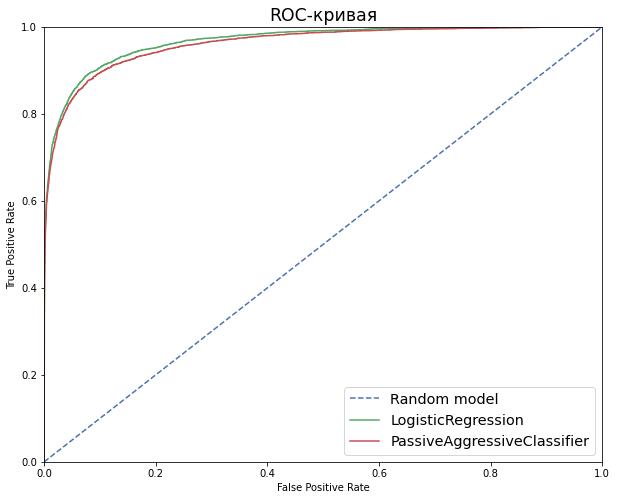

In [50]:
plt.figure(figsize=[10, 8])

plt.plot([0, 1], [0, 1], linestyle='--', label='Random model')

model = LogisticRegression()
model.set_params(C=10,
                 class_weight=classes,
                 random_state=STATE,
                 solver='liblinear')
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = model.predict(features_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики модели LogisticRegression')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

model = PassiveAggressiveClassifier()
model.set_params(C=0.1,
                 class_weight='balanced',
                 max_iter=1863,
                 n_jobs=-1,
                 random_state=STATE)
model.fit(features_train, target_train)
probabilities_test = model.decision_function(features_test)
probabilities_one_test = probabilities_test
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = model.predict(features_test)
plt.plot(fpr, tpr, label='PassiveAggressiveClassifier')
print('Метрики модели PassiveAggressiveClassifier')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая", fontsize='xx-large')
plt.show()

На тестовой выбоке по метрике f1 лучше всего себя показала модель LogisticRegression. Данная модель обладает высокими показателями Precision и Accuracy. Это говорит нам, что токсичные комментарии находятся лучше.
<br>Модель PassiveAggressiveClassifier несколько уступает LogisticRegression в метрике f1 и Accuracy, однако имеет несколько более высокое значение Recall и гораздо более короткое время обучения, что может оказаться не лишним, если необходимо быстродействие при обучении.  